# **<center> Adversarial attacks <center>**



In [21]:
exec(open('cifar_utils.py').read())
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from keras.models import load_model

1- Import the cifar dataset

In [22]:
x_train, train_labels, x_test, test_labels = load_CIFAR10_data()
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

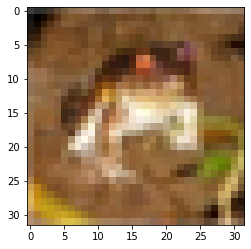

In [23]:
plt.imshow(x_train[0])

2- Train a base model

In [24]:
input_shape = (32,32,3)
model = build_model_base_CNN(input_shape)

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)       

In [26]:
## hot encoding of the labels
y_train = keras.utils.to_categorical(train_labels, 10) 
y_test = keras.utils.to_categorical(test_labels, 10)

In [27]:

rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=15)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


history = model.fit(x_train, y_train, epochs=100, batch_size=64,verbose=1,validation_split = 0.2,callbacks=[es,mc,rlrop])


Epoch 1/100
621/625 [============================>.] - ETA: 0s - loss: 2.1468 - accuracy: 0.2632
Epoch 00001: val_accuracy improved from -inf to 0.18790, saving model to best_model.h5
625/625 [==============================] - 5s 8ms/step - loss: 2.1448 - accuracy: 0.2638 - val_loss: 3.7362 - val_accuracy: 0.1879
Epoch 2/100
622/625 [============================>.] - ETA: 0s - loss: 1.6395 - accuracy: 0.3943
Epoch 00002: val_accuracy improved from 0.18790 to 0.49760, saving model to best_model.h5
625/625 [==============================] - 4s 7ms/step - loss: 1.6387 - accuracy: 0.3946 - val_loss: 1.3902 - val_accuracy: 0.4976
Epoch 3/100
624/625 [============================>.] - ETA: 0s - loss: 1.3617 - accuracy: 0.5132
Epoch 00003: val_accuracy improved from 0.49760 to 0.57760, saving model to best_model.h5
625/625 [==============================] - 4s 7ms/step - loss: 1.3614 - accuracy: 0.5133 - val_loss: 1.2543 - val_accuracy: 0.5776
Epoch 4/100
623/625 [============================

Plot Training loss

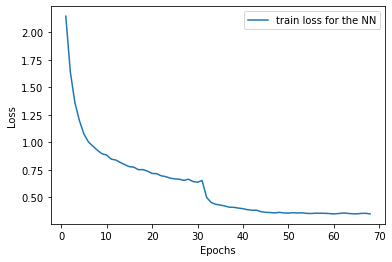

In [28]:


history_dict = history.history
loss_values = history_dict['loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, label='train loss for the NN')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Plot validation loss

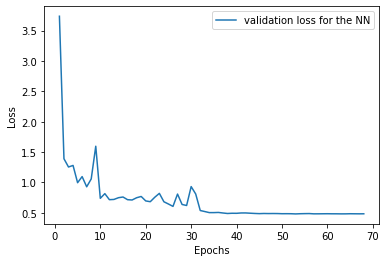

In [29]:

loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, label='validation loss for the NN')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

3- Evaluate on train and test set 

In [30]:
print("Base accuracy on regular train images:", model.evaluate(x=x_train, y=y_train, verbose=0)[1])

Base accuracy on regular train images: 0.9208800196647644


In [31]:
print("Base accuracy on regular test images:", model.evaluate(x=x_test, y=y_test, verbose=0)[1])

Base accuracy on regular test images: 0.8497999906539917


*4 - Generate FGSM ATTACK

Example on one image and different values of epsilon, we plot the predictions as well as the confidence of the predictions



In [32]:
image = x_train[1,:]
image_label = y_train[1,:].reshape((1,-1))

In [33]:
perturbations = adversarial_pattern(image.reshape((-1,32,32,3)), image_label).numpy()


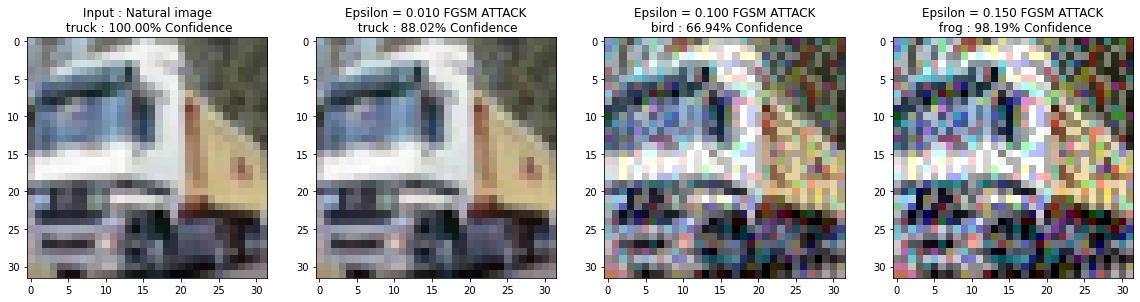

In [34]:
fig = plt.figure(figsize=(25,5))
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps)+' FGSM ATTACK' if eps else 'Input : Natural image')
                for eps in epsilons]

for i in range(len(epsilons)) : 
  adversarial = image + perturbations * epsilons[i]
  adversarial = tf.clip_by_value(adversarial, 0, 1).numpy()
  label = classes[model.predict(adversarial.reshape(-1,32,32,3)).argmax()]
  confidence = model.predict(adversarial.reshape(-1,32,32,3)).max()
  subplot = fig.add_subplot(1,5,i+1)
  plt.imshow(adversarial.reshape(32,32,3))
  subplot.title.set_text(descriptions[i]+'\n {} : {:.2f}% Confidence'.format(label, confidence*100))

Compute the accuracy of the model on some adversarial examples only :

In [61]:
batch_size = 10000
eps = 0.1
x_adversarial_test, y_adversarial_test = generate_adversarials_test_FGSM(batch_size, eps)



In [62]:
print("Accuracy on adversarial images for epsilon = 0.1:", model.evaluate(x=np.array(x_adversarial_test).reshape(-1,32,32,3), y=np.array(y_adversarial_test), verbose=0)[1])

Accuracy on adversarial images for epsilon = 0.1: 0.09279999881982803


Plot the accuracy for different epsilons : 

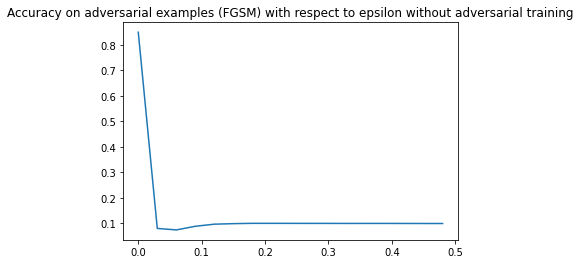

In [37]:
epsilons2 = np.arange(0,0.5,0.03)
batch_size = 10000
accuracies = []
for eps in epsilons2 :
  x_adversarial_test, y_adversarial_test = generate_adversarials_test_FGSM(batch_size, eps)
  accuracy =  model.evaluate(x=np.array(x_adversarial_test).reshape(-1,32,32,3), y=np.array(y_adversarial_test), verbose=0)[1]
  accuracies.append(accuracy)
plt.plot(epsilons2,accuracies)
plt.title('Accuracy on adversarial examples (FGSM) with respect to epsilon without adversarial training')
plt.show()


5- Adversarial training (training on adversarial images )

we generate train data : 

In [20]:
##  a portion of adversarial
n_examples = 20000
eps = 0.1
x_adversarial_train, y_adversarial_train = generate_adversarials_train_FGSM(n_examples, eps)




In [41]:
## portion of  regular examples
indexes = np.random.choice(x_train.shape[0],30000)
x_regular = x_train[indexes]
y_regular = y_train[indexes]

In [43]:
x_train_mixed = np.concatenate([x_regular,x_adversarial_train],axis = 0)

In [44]:
y_train_mixed = np.concatenate([y_regular,y_adversarial_train],axis = 0)

In [54]:
from sklearn.utils import shuffle
x_train_mixed,y_train_mixed = shuffle(x_train_mixed,y_train_mixed, random_state = 0)

define the second model and train it 

In [55]:
input_shape = (32,32,3)
model_adv = build_model_base_CNN(input_shape)

rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=15)
mc = ModelCheckpoint('best_model_adv.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history_adv = model_adv.fit(np.array(x_train_mixed).reshape(-1,32,32,3), np.array(y_train_mixed), epochs=100, batch_size=64,verbose=1,validation_split = 0.2,callbacks=[es,mc,rlrop])


Epoch 1/100
496/500 [============================>.] - ETA: 0s - loss: 2.2309 - accuracy: 0.1942
Epoch 00001: val_accuracy improved from -inf to 0.24737, saving model to best_model_adv.h5
500/500 [==============================] - 4s 7ms/step - loss: 2.2282 - accuracy: 0.1949 - val_loss: 1.8634 - val_accuracy: 0.2474
Epoch 2/100
493/500 [============================>.] - ETA: 0s - loss: 1.8519 - accuracy: 0.2896
Epoch 00002: val_accuracy improved from 0.24737 to 0.36575, saving model to best_model_adv.h5
500/500 [==============================] - 4s 7ms/step - loss: 1.8499 - accuracy: 0.2901 - val_loss: 1.7444 - val_accuracy: 0.3658
Epoch 3/100
497/500 [============================>.] - ETA: 0s - loss: 1.7135 - accuracy: 0.3527
Epoch 00003: val_accuracy improved from 0.36575 to 0.37475, saving model to best_model_adv.h5
500/500 [==============================] - 4s 7ms/step - loss: 1.7136 - accuracy: 0.3530 - val_loss: 1.7066 - val_accuracy: 0.3747
Epoch 4/100
497/500 [================

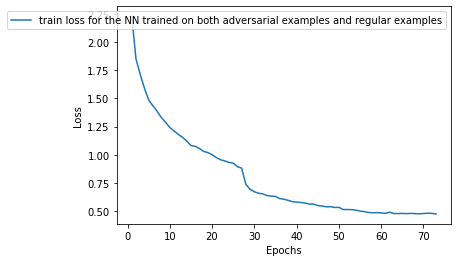

In [57]:

history_dict = history_adv.history
loss_values = history_dict['loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, label='train loss for the NN trained on both adversarial examples and regular examples')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

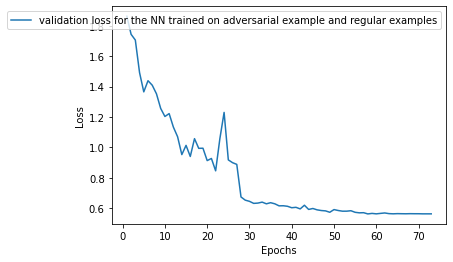

In [58]:

loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, label='validation loss for the NN trained on adversarial example and regular examples')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [59]:

print("Defended accuracy on regular images:", model_adv.evaluate(x=x_test, y=y_test, verbose=0)[1])

Defended accuracy on regular images: 0.7605999708175659


In [63]:
print("Defended accuracy on adversarial images:", model_adv.evaluate(x=np.array(x_adversarial_test).reshape(-1,32,32,3), y=np.array(y_adversarial_test), verbose=0)[1])

Defended accuracy on adversarial images: 0.5677000284194946


Results of adversarial training : 
* 76% accuracy on regular test images which is less that 85% obtained by normal neural network. <br>
* 56,7% accuracy on adversarial test images which is better than 9% obtained by normal neural network. 